In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

%matplotlib inline

#setting the directory path that I'll be using for this project.
import os
print(os.listdir("C:/Users/gagd2/Desktop/Connect/Urbanation"))

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'beach-weather-stations-automated-sensors.csv', 'Crimes_-_2001_to_present.csv', 'Madsen_Sanjeev_ProjectProposal.docx', 'Sanjeev_Madsens_Visualizations.ipynb', 'Sanjeev_Madsen_Crime&Weather.ipynb', 'Sanjeev_Madsen_FinalPresentation(ChicagoCrime).pptx', 'Sanjeev_Madsen_FinalProject(mine).docx', 'Sanjeev_Madsen_ProjectFinal.ipynb', 'temperature.csv', 'weather.csv', '~$njeev_Madsen_FinalProject(mine).docx', '~$Sanjeev_Madsen_FinalPresentation(ChicagoCrime).pptx']


**This section is where I read the weather and crime data into their respective dataframes.** 


In [4]:
crime_chi = pd.read_csv("Crimes_-_2001_to_present.csv", usecols=["Date", "Block","IUCR","Description",
                                                                 "Primary Type","Beat","Location Description",
                                                                 "Arrest","Domestic","Year",
                                                                 "District","Ward","Community Area","FBI Code",
                                                                 "Latitude","Longitude","Location","Zip Codes"],
                        error_bad_lines=False)

In [5]:
weather = pd.read_csv("beach-weather-stations-automated-sensors.csv", usecols=["Measurement Timestamp", "Air Temperature", "Total Rain"], error_bad_lines=False)

In [6]:
#rename the columns of the weather dataset and convert the date column to datetime datatype.
weather.columns = ['Date', 'Temp', 'Total Precipitation']
weather.loc[:,'Date'] = pd.to_datetime(weather.loc[:,'Date'])
weather['Date'] = weather['Date'].dt.date

In [7]:
#This cell takes a long time to run - converting the crime dataset Date to datetime datatype
crime_chi.loc[:,'Date'] = pd.to_datetime(crime_chi.loc[:,'Date'], dayfirst=True, yearfirst=False)
crime_chi['Date'] = crime_chi['Date'].dt.date

In [8]:
#sort the crime dataset by date values and drop all the na's from the weather dataset since those rows are of no value to us.
crime_chi = crime_chi.sort_values(by=['Date'])
weather = weather.dropna()

In [9]:
#filtering both the datasets between years 2010 to 2017 instead of analyzing everything.
start_date = dt.date(2015,4,25)
# print(start_date)
end_date = dt.date(2017,1,18)
# print(end_date)
date_mask = (weather['Date'] > start_date) & (weather['Date'] <= end_date)
date_mask2 = (crime_chi['Date'] > start_date) & (crime_chi['Date'] <= end_date)

In [10]:
#apply the filters to the original datasets.
weather = weather.loc[date_mask]
crime_chi = crime_chi.loc[date_mask2]

In [11]:
#join the crime and weather datasets by the common column Date and write this into a new CSV file.
CW_data = weather.join(crime_chi, on='Date', how='outer',
                                    lsuffix='_left', rsuffix='_right')
export_csv = CW_data.to_csv (r'CW_merged_Updated.csv', index = None, header=True)

In [12]:
#import or read in this new merged CSV file to do further analysis. 
clean_CW = pd.read_csv("CW_merged_Updated.csv", error_bad_lines=False)
#drop duplicate date columns
CrimeWea = clean_CW.drop(["Date_left","Date_right"], axis=1)
CrimeWea.tail()

C:\Users\gagd2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Temp,Total Precipitation,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Location,Zip Codes
491193,615014,NaN,NaN,029XX W FLOURNOY ST,2024,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,1135.0,11.0,2.0,27.0,18,2017.0,41.872848,-87.699166,"(41.872848437, -87.699165589)",21184.0
491194,615013,NaN,NaN,036XX S WABASH AVE,0545,ASSAULT,PRO EMP HANDS NO/MIN INJURY,"SCHOOL, PUBLIC, BUILDING",False,False,213.0,2.0,3.0,35.0,08A,2017.0,41.828075,-87.624904,"(41.8280754, -87.624904486)",4301.0
491195,615012,NaN,NaN,001XX S CLINTON ST,1121,DECEPTIVE PRACTICE,COUNTERFEITING DOCUMENT,STREET,False,False,121.0,1.0,2.0,28.0,10,2017.0,41.880055,-87.641138,"(41.880054533, -87.641137777)",14914.0
491196,615076,NaN,NaN,010XX E 87TH ST,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,NaN,False,False,412.0,4.0,8.0,44.0,11,2017.0,41.736736,-87.598532,"(41.736736273, -87.598532484)",21546.0
491197,614976,NaN,NaN,077XX S COLES AVE,1245,DECEPTIVE PRACTICE,PAY TV SERVICE OFFENSES,RESIDENCE,False,False,421.0,4.0,7.0,43.0,11,2017.0,41.755903,-87.554440,"(41.755902933, -87.554440264)",22538.0


In [13]:
#drop nan values from the merged dataset
CrimeWea = CrimeWea.dropna()


In [14]:
#Let's do some EDA
#calculate the total frequency of all crimes per day. 
total_crimes = (crime_chi.groupby(['Date']).size())
avg_weather = weather.groupby(['Date']).mean()
print(avg_weather)
print(total_crimes)

                 Temp  Total Precipitation
Date                                      
2015-04-30   6.100000             2.500000
2015-05-26  22.242857             4.928571
2015-05-27  21.700000             5.472727
2015-05-28  20.211111             5.600000
2015-05-29  24.100000             6.756522
2015-05-30  15.125000             9.441667
2015-05-31   8.282609            10.300000
2015-06-01   9.539130            10.300000
2015-06-02  11.945000            10.300000
2015-06-03  16.220000            10.300000
2015-06-04  22.378947            10.300000
2015-06-05  14.023529            10.300000
2015-06-06  11.991304            10.300000
2015-06-07  21.386957            15.869565
2015-06-08  22.845455            21.040909
2015-06-09  23.070000            27.800000
2015-06-10  25.114286            27.800000
2015-06-11  16.714286            28.166667
2015-06-12  14.428571            34.061905
2015-06-13  17.268182            36.090909
2015-06-14  23.309091            61.959091
2015-06-15 

**Creating a new dataframe containing [Date, Total Daily Crimes, Average Temperature for the Day[C]]**

In [15]:
total_crimes.head()

Date
2015-04-26    718
2015-04-27    719
2015-04-28    718
2015-04-29    765
2015-04-30    665
dtype: int64

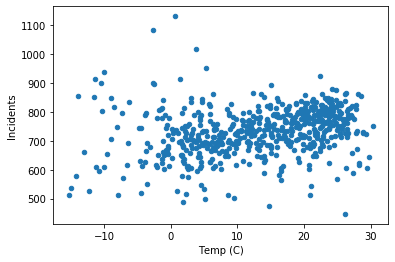

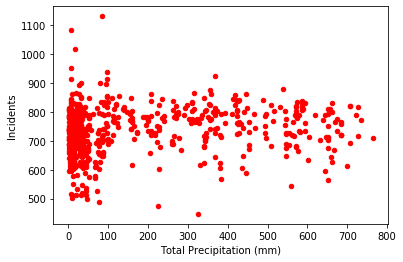

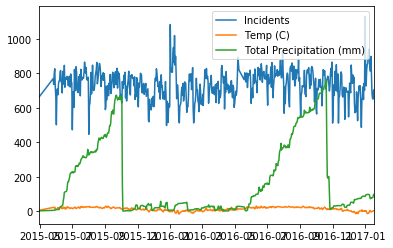

In [16]:
#create a merged data frame of the crimes and weather and draw a plot with precipitation, temperature and number of incidents
frames = [total_crimes, avg_weather]
result = pd.concat(frames, axis=1, sort=True)
result = result.dropna()
result.columns = ['Incidents','Temp (C)', 'Total Precipitation (mm)']
result.plot(kind='Scatter', x='Temp (C)', y='Incidents')
result.plot(kind='Scatter', x='Total Precipitation (mm)', y='Incidents', color='r')
result.plot()


The above scatterplots show that the number of incidents increase by a rise in temperature  and there are also a lot of incidents happening when there is heavy rainfall. But when there is very heavy rainfall or flooding, the number of incidents are relatively lesser than what it is when the rainfall is between 0 to 50mm.

In [17]:
result.head()

,Incidents,Temp (C),Total Precipitation (mm)
2015-04-30,665,6.100000,2.500000
2015-05-26,770,22.242857,4.928571
2015-05-27,736,21.700000,5.472727
2015-05-28,800,20.211111,5.600000
2015-05-29,827,24.100000,6.756522


[[2.21312979]]
[704.77035152]


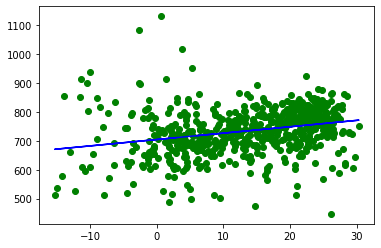

[[0.05772936]]
[723.59294147]


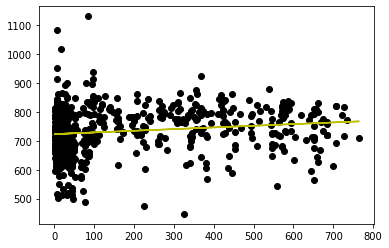

In [18]:
result.isnull().values.any()
regr = LinearRegression()

X = pd.DataFrame(result['Temp (C)'])
y = pd.DataFrame(result['Incidents'])
# print(y)
regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)
pred = regr.predict(X)
plt.scatter(result['Temp (C)'], result['Incidents'], color='g')
plt.plot(X, pred, color='b')
plt.show()

X2 = pd.DataFrame(result['Total Precipitation (mm)'])
regr2 = LinearRegression()
regr2.fit(X2, y)
p2 = regr2.predict(X2)
print(regr2.coef_)
print(regr2.intercept_)
plt.scatter(result['Total Precipitation (mm)'], result['Incidents'], color='k')
plt.plot(X2, p2, color='y')
plt.show()


**If the relationship between temperature and weather was strongly correlated, we could qualitatively observe that more extreme weather resulted in more incidents.**